## Pilot Run #1
This notebook is our first pilot run of aggregating three crop yield indicators and running a machine learning model on them. The three indicators being used are NDVI, rainfall, and land surface temperature. While this is a meaningful step, it is by no means free of errors. Here I will keep a list of things we still need to improve on. This is a pilot run for a reason, we are moving quickly through the data collection and modeling processes so that we can gain an idea of where we are/heading before we invest significant amounts of time into any one process.  
### Notes 
 - Each indicator is a mean value from June 20 to November 1 (the estimated growing season)
 - Image collections are not filtered for cloudiness upon data collection; this leaves chance for obscured numbers 
 - Years are from 2000 to 2020
 - The crop yield data is only for maize 
 - I control naming conventions of data from GEE, if needed I can go back and download it again

In [7]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import datasets
import statsmodels.api as sm
from stargazer.stargazer import Stargazer, LineLocation
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from joblib import dump, load
from sklearn.preprocessing import PolynomialFeatures

### Step 1: Loop through each folder with data files and create a dictionary of data frames  
Each csv file within its respective folder is named "YEAR_mean_indicator". I will create function to iterate through all files in each directory and add them to their dictionary, with the key being the year.

In [8]:
# name directories in file path 
ndvi_dir = 'mean_ndvi'
lst_dir = 'mean_lst'
rain_dir = 'mean_rainfall'
# create dictionaries to store each individual df
ndvi_dict = {}
lst_dict = {}
rain_dict = {}

In [9]:
def create_dict(dir, dict):
    '''Params dir and dict are the directory name and dictionary to store dataframes in'''
    for filename in os.listdir(dir):
        fpath = os.path.join(dir, filename)         # creates the file path name
        if os.path.isfile(fpath):                   # make sure the file is real
            year = filename[:4]                 # year is at index 0-3 in filename
            dict[int(year)] = pd.read_csv(fpath)    # input dictionary now has key of year and value of df for that year

In [10]:
create_dict(ndvi_dir, ndvi_dict)
create_dict(lst_dir, lst_dict)
create_dict(rain_dir, rain_dict)

In [11]:
# check to see if created correctly 
ndvi_dict[2007]
lst_dict[2019]
rain_dict[2012]

,system:index,district_name,mean_rain,.geo
0,00000000000000000001,Karaga,6.073907,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,00000000000000000002,Kpandai,6.519508,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,00000000000000000004,Nanumba South,7.731603,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,00000000000000000005,Saboba,7.357560,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,00000000000000000007,Nanton,6.000094,"{""type"":""MultiPoint"",""coordinates"":[]}"
5,0000000000000000000a,Tolon,5.975546,"{""type"":""MultiPoint"",""coordinates"":[]}"
6,0000000000000000000b,Kumbungu,5.882393,"{""type"":""MultiPoint"",""coordinates"":[]}"
7,0000000000000000000d,Mion,7.039732,"{""type"":""MultiPoint"",""coordinates"":[]}"
8,0000000000000000000e,Tatale Sanguli,7.867594,"{""type"":""MultiPoint"",""coordinates"":[]}"
9,0000000000000000000f,Zabzugu,7.951390,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [12]:
ndvi_dict.keys()

dict_keys([2002, 2015, 2011, 2006, 2016, 2001, 2005, 2012, 2018, 2008, 2009, 2020, 2019, 2013, 2004, 2000, 2017, 2007, 2010, 2014, 2003])

### Step 2: Reorder dictionary chronologically 
The keys in the dictionary are not in order, which will be a problem come time to make one df. This function will reorder all the keys chronologically 

In [13]:
def reorder(dict):
    sorted_keys = sorted(list(dict.keys()))
    sorted_dict = {i: dict[i] for i in sorted_keys}
    return sorted_dict

In [14]:
ndvi_dict = reorder(ndvi_dict)
ndvi_dict.keys()

dict_keys([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [15]:
lst_dict = reorder(lst_dict)
lst_dict.keys()

dict_keys([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [16]:
rain_dict = reorder(rain_dict)
rain_dict.keys()

dict_keys([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

### Step 3: Clean dfs
Each dataframe within each dictionary are formatted the same. This function will get rid of unwanted columns and rename needed columns to prepare for the big merge

In [17]:
print(ndvi_dict[2000].columns)
print(lst_dict[2002].columns)
print(rain_dict[2007].columns)

Index(['system:index', 'district_name', 'mean_ndvi', '.geo'], dtype='object')
Index(['system:index', 'district_name', 'mean_lst', '.geo'], dtype='object')
Index(['system:index', 'district_name', 'mean_rain', '.geo'], dtype='object')


In [18]:
def clean_dfs(dict, indicator):
    '''dict is dictionary of dfs to clean, indicator is name value column of each df. This can
    be found in the mean_ columns above. Last line sets index to district name to make 
    concat all dfs easier.'''
    for k, v in dict.items():
        year = k
        v.drop(columns=['system:index', '.geo'], inplace=True)
        v.rename({f'mean_{indicator}': f'{indicator}'+str(year)}, axis=1, inplace=True)
        v.set_index(['district_name'], inplace=True)


In [19]:
clean_dfs(ndvi_dict, 'ndvi')

In [20]:
clean_dfs(lst_dict, 'lst')

In [21]:
clean_dfs(rain_dict, 'rain')

In [22]:
# check 
#lst_dict[2000]
#ndvi_dict[2000]
rain_dict[2000]

,rain2000
district_name,
Karaga,5.564226
Kpandai,6.544151
Nanumba South,7.092694
Saboba,6.357444
Nanton,5.888660
Tolon,5.412446
Kumbungu,5.401193
Mion,6.454891
Tatale Sanguli,7.292368


### Step 4: Concat all dfs within each indicator

In [23]:
ndvi_df = pd.concat(ndvi_dict.values(), axis=1)
lst_df = pd.concat(lst_dict.values(), axis=1)
rain_df = pd.concat(rain_dict.values(), axis=1)

In [24]:
ndvi_df.head()

,ndvi2000,ndvi2001,ndvi2002,ndvi2003,ndvi2004,ndvi2005,ndvi2006,ndvi2007,ndvi2008,ndvi2009,...,ndvi2011,ndvi2012,ndvi2013,ndvi2014,ndvi2015,ndvi2016,ndvi2017,ndvi2018,ndvi2019,ndvi2020
district_name,,,,,,,,,,,,,,,,,,,,,
Karaga,5866.053784,5712.805664,6224.991423,6021.110706,6125.029744,5613.705729,5856.846145,5877.891930,5918.580750,5936.023059,...,6113.646040,5885.694090,5542.839296,5188.862715,5376.902643,5353.887285,6309.561163,5981.805725,5803.360776,5557.100079
Kpandai,4992.504865,4323.272730,5596.314017,5162.024161,5056.996919,5448.941369,5136.992608,5690.597181,5105.658520,4699.130845,...,5093.398909,5146.390069,4343.289555,4164.866428,5291.831551,4162.433267,5004.531186,5296.869700,4720.576233,5410.579669
Nanumba South,5539.840725,4848.457066,5788.478692,5259.871816,5853.903901,5644.949464,5374.061852,5771.445803,5658.583998,5418.882682,...,5687.111251,5297.437079,5003.628171,4619.618465,5485.997348,5004.308936,5507.457360,5315.106623,5274.636201,5440.635414
Saboba,5581.632022,5400.724671,6059.008676,6022.246454,6013.777599,5913.779644,5789.662198,6013.168868,6011.322139,5636.662853,...,6281.129489,5884.147988,5549.236842,5567.608557,5654.720093,5838.789101,6255.655693,5905.484659,5867.789951,5476.609415
Nanton,5488.219405,5455.308158,5787.657142,6162.461827,6078.797582,5505.137465,5460.256602,5581.044267,5588.314278,5950.577817,...,5951.433398,5637.378845,5509.064368,5135.501485,4987.235265,4714.249673,6125.702064,5842.961516,5711.404675,5245.879027


In [25]:
lst_df.head()

,lst2000,lst2001,lst2002,lst2003,lst2004,lst2005,lst2006,lst2007,lst2008,lst2009,...,lst2011,lst2012,lst2013,lst2014,lst2015,lst2016,lst2017,lst2018,lst2019,lst2020
district_name,,,,,,,,,,,,,,,,,,,,,
Karaga,15498.877794,15514.935198,15449.574318,15465.010288,15318.358905,15414.831509,15491.360333,15420.382158,15439.959882,15417.135740,...,15452.698715,15365.929271,15422.592413,15469.473567,15547.292865,15522.737169,15543.368487,15527.916044,15565.842010,15453.540639
Kpandai,15240.665521,15419.022347,15256.001222,15283.369591,15215.289140,15226.824146,15312.958170,15300.846663,15232.752713,15224.495158,...,15283.072834,15226.916565,15251.060298,15340.986775,15247.786739,15273.291768,15428.323386,15294.643322,15424.554603,15298.036083
Nanumba South,15305.424196,15464.811621,15298.264860,15340.125507,15232.198895,15285.600911,15377.116747,15324.264128,15313.407841,15263.898949,...,15337.299107,15270.112294,15325.438372,15375.633834,15326.864193,15333.424758,15498.844733,15385.532489,15528.066578,15373.398870
Saboba,15458.429732,15533.507001,15395.404332,15422.417897,15338.510272,15392.101435,15453.663172,15433.495009,15477.085221,15395.604101,...,15404.693470,15364.996177,15448.852545,15451.475423,15468.881776,15461.271510,15567.447773,15469.117919,15590.667626,15488.067202
Nanton,15447.818523,15498.658317,15471.461800,15447.344971,15323.516092,15409.607391,15493.411434,15432.822226,15413.941841,15385.817908,...,15450.955287,15369.507843,15423.119994,15449.742840,15518.950060,15513.010363,15548.457394,15461.713095,15577.459749,15418.335950


In [26]:
rain_df.head()

,rain2000,rain2001,rain2002,rain2003,rain2004,rain2005,rain2006,rain2007,rain2008,rain2009,...,rain2011,rain2012,rain2013,rain2014,rain2015,rain2016,rain2017,rain2018,rain2019,rain2020
district_name,,,,,,,,,,,,,,,,,,,,,
Karaga,5.564226,4.274813,4.390874,5.840573,5.094916,5.032072,5.751531,5.875880,5.468678,6.434939,...,6.129502,6.073907,4.171192,4.920700,5.490458,5.828353,4.345145,5.988821,6.085621,5.990622
Kpandai,6.544151,4.315490,6.637862,6.910923,5.747969,4.825486,6.191360,7.645500,7.055889,8.106049,...,7.994971,6.519508,4.490634,5.725668,5.100224,7.118922,5.971822,6.748953,6.648325,5.492299
Nanumba South,7.092694,5.022905,7.048970,7.527294,6.749336,5.633701,6.571091,7.681272,7.016718,8.966814,...,7.932381,7.731603,4.901104,6.198384,6.115834,7.289198,5.918912,6.707900,6.593899,6.181447
Saboba,6.357444,5.331733,5.710514,6.806085,5.800439,5.572953,5.809063,6.042160,6.167608,7.588160,...,6.565091,7.357560,4.294218,5.813201,5.904939,7.206322,5.279898,6.247458,6.311079,7.110850
Nanton,5.888660,4.273429,4.364878,5.695852,5.261449,4.777994,5.522952,5.944496,5.928243,7.184719,...,6.090848,6.000094,3.917311,5.273507,5.312896,6.478742,4.179434,6.625536,6.393048,5.745838


### Step 5: Turn dfs from wide format to long format
This essentially creates a MultiIndex df (panel data) of District then year. 

In [27]:
ndvi_df.reset_index(inplace=True)
ndvi_final = pd.wide_to_long(ndvi_df, 'ndvi', 'district_name', 'year')
ndvi_final.head()

,,ndvi
district_name,year,
Karaga,2000,5866.053784
Kpandai,2000,4992.504865
Nanumba South,2000,5539.840725
Saboba,2000,5581.632022
Nanton,2000,5488.219405


In [28]:
lst_df.reset_index(inplace=True)
lst_final = pd.wide_to_long(lst_df, 'lst', 'district_name', 'year')
lst_final.head()

,,lst
district_name,year,
Karaga,2000,15498.877794
Kpandai,2000,15240.665521
Nanumba South,2000,15305.424196
Saboba,2000,15458.429732
Nanton,2000,15447.818523


In [29]:
rain_df.reset_index(inplace=True)
rain_final = pd.wide_to_long(rain_df, 'rain', 'district_name', 'year')
rain_final.head()

,,rain
district_name,year,
Karaga,2000,5.564226
Kpandai,2000,6.544151
Nanumba South,2000,7.092694
Saboba,2000,6.357444
Nanton,2000,5.888660


### Step 6: Merge all three dfs into one large one

In [30]:
indic_df = ndvi_final.join([lst_final, rain_final])
indic_df.head()
indic_df.shape

(1113, 3)

### Step 7: Integrate yield data into this dataframe
I have an accompanying district ID key excel file that I will need to upload. Crop 1 is maize. Need to figure out a way to map this key to district names and then put it into big df

In [31]:
yields = pd.read_excel('/Users/gavmross/Desktop/School/cua_spring_23/ghana/MOFA_YieldData_Maize.xlsx')
yields.head()

,DistID,Year,Crop,Yield
0,1,1992.0,1,1.300000
1,1,1993.0,1,1.300000
2,1,1994.0,1,1.600000
3,1,1995.0,1,1.718848
4,1,1996.0,1,1.400000


In [32]:
yields.columns = ['DistID', 'Year', 'Crop', 'Yield']
yields.head()

,DistID,Year,Crop,Yield
0,1,1992.0,1,1.300000
1,1,1993.0,1,1.300000
2,1,1994.0,1,1.600000
3,1,1995.0,1,1.718848
4,1,1996.0,1,1.400000


In [33]:
key = pd.read_excel("/Users/gavmross/Desktop/School/cua_spring_23/ghana/DistrictKey.xlsx")
key

,Dist,Unnamed: 1
0,1,Gushiegu
1,2,Karaga
2,3,Kpandai
3,4,NanumbaNorth
4,5,NanumbaSouth
5,6,Saboba
6,7,Savelugu
7,8,Nanton
8,9,Sagnerigu
9,10,Tamale


In [34]:
key.rename({"Dist": "District ID", 'Unnamed: 1': "District Name"}, inplace=True, axis=1)
key.head()

,District ID,District Name
0,1,Gushiegu
1,2,Karaga
2,3,Kpandai
3,4,NanumbaNorth
4,5,NanumbaSouth


In [35]:
# create mapper dictionary using key 
mapper = dict(zip(key['District ID'], key['District Name']))
mapper

{1: 'Gushiegu',
 2: 'Karaga',
 3: 'Kpandai',
 4: 'NanumbaNorth',
 5: 'NanumbaSouth',
 6: 'Saboba',
 7: 'Savelugu',
 8: 'Nanton',
 9: 'Sagnerigu',
 10: 'Tamale',
 11: 'Tolon',
 12: 'Kumbungu',
 13: 'Yendi',
 14: 'Mion',
 15: 'Tatale',
 16: 'Zabzugu',
 17: 'Yunyoo',
 18: 'Bunkpurugu',
 19: 'Chereponi',
 20: 'EastMamprusi',
 21: 'MampruguMoagduri',
 22: 'WestMamprusi',
 23: 'Bole',
 24: 'CentralGonja',
 25: 'EastGonja',
 26: 'SawlaTunaKalba',
 27: 'WestGonja',
 28: 'NorthGonja',
 29: 'BuilsaNorth',
 30: 'BuilsaSouth',
 31: 'KasinaNankana',
 32: 'Bongo',
 33: 'Bolgatanga',
 34: 'BawkuEast',
 35: 'BawkuWest',
 36: 'Garu',
 37: 'Talensi',
 38: 'KassenaNankanaMunicipal',
 39: 'KassenaNankanaWest',
 40: 'Binduri',
 41: 'Pusiga',
 42: 'Nabdam',
 43: 'WaWest',
 44: 'WaEast',
 45: 'WaMunicipal',
 46: 'Lawra',
 47: 'SissalaEast',
 48: 'SissalaWest',
 49: 'Jirapa',
 50: 'LambussieKarnie',
 51: 'Nadowli',
 52: 'DafiamaBussieIssa',
 53: 'Nandom'}

In [36]:
yields['DistName'] = yields['DistID'].map(mapper)

In [37]:
yields = yields[['DistID', 'DistName', 'Year', 'Yield', 'Crop']]
yields.drop(['Crop', 'DistID'], axis=1, inplace=True)       # once i have mapped names, do not need ID anymore
yields.head()

,DistName,Year,Yield
0,Gushiegu,1992.0,1.300000
1,Gushiegu,1993.0,1.300000
2,Gushiegu,1994.0,1.600000
3,Gushiegu,1995.0,1.718848
4,Gushiegu,1996.0,1.400000


In [38]:
# sort by year then name to get it in same format as other df
yields_sort = yields.sort_values(by=['Year', 'DistName'])
yields_sort.head()

,DistName,Year,Yield
654,Bole,1992.0,1.3
509,Bunkpurugu,1992.0,0.6
683,CentralGonja,1992.0,1.3
538,Chereponi,1992.0,1.3
712,EastGonja,1992.0,1.7


In [39]:
# rename to have same naming conventions as other dfs
yields_final = yields_sort.rename({'DistName': 'district_name', 'Year': 'year', 'Yield': 'yield'}, axis=1)
yields_final.head()

,district_name,year,yield
654,Bole,1992.0,1.3
509,Bunkpurugu,1992.0,0.6
683,CentralGonja,1992.0,1.3
538,Chereponi,1992.0,1.3
712,EastGonja,1992.0,1.7


In [40]:
# final df is only 2000 to 2020
yields_final = yields_final.loc[(yields_final['year'] > 1999) & (yields_final['year'] < 2021)]
yields_final.reset_index(inplace=True)

### Step 8: Combine yield df into indicator df
Need to strip indicator df of spaces because yield df doesnt have any spaces in the district_name column, then reorder indicator df alphabetically to make them ordered identically 

In [41]:
# rest index first to order it properly 
indic_df.reset_index(inplace=True)

In [42]:
indic_df.head()

,district_name,year,ndvi,lst,rain
0,Karaga,2000,5866.053784,15498.877794,5.564226
1,Kpandai,2000,4992.504865,15240.665521,6.544151
2,Nanumba South,2000,5539.840725,15305.424196,7.092694
3,Saboba,2000,5581.632022,15458.429732,6.357444
4,Nanton,2000,5488.219405,15447.818523,5.888660


In [43]:
# strip all space
indic_df['district_name'] = indic_df['district_name'].str.replace(' ', '')

In [44]:
indic_final = indic_df.sort_values(by=['year', 'district_name'])

In [45]:
indic_final

,district_name,year,ndvi,lst,rain
41,Bawku,2000,4414.133649,15533.286044,4.807214
30,BawkuWest,2000,5627.316414,15478.890897,4.839396
35,Binduri,2000,4995.406750,15520.691698,4.882226
16,Bole,2000,5094.237214,15295.688814,4.204937
40,Bolgatanga,2000,6031.486869,15436.132054,4.479659
...,...,...,...,...,...
1081,WestGonja,2020,6121.684429,15336.061934,4.133532
1087,WestMamprusi,2020,5426.934655,15523.531664,6.077753
1075,Yendi,2020,5705.304257,15444.081762,6.634903
1082,Yunyoo-Nasuan,2020,5095.734431,15550.997291,6.234287


In [46]:
yields_final

,index,district_name,year,yield
0,975,BawkuEast,2000.0,1.500000
1,1003,BawkuWest,2000.0,2.000000
2,1143,Binduri,2000.0,NaN
3,662,Bole,2000.0,1.000000
4,947,Bolgatanga,2000.0,0.600000
...,...,...,...,...
1108,798,WestGonja,2020.0,2.680523
1109,653,WestMamprusi,2020.0,2.161712
1110,388,Yendi,2020.0,1.264602
1111,508,Yunyoo,2020.0,2.269798


In [47]:
# looks like the yields and indicator dfs are in the same order, look at one year to make sure

In [48]:
indic_final.loc[indic_final['year'] == 2000].shape

(53, 5)

In [49]:
yields_final.loc[yields_final['year'] == 2000].shape

(53, 4)

In [50]:
#looks like there are slightly different naming conventions, but shape is same so I will merge them

In [51]:
yields_final.reset_index(drop=True, inplace=True)
indic_final.reset_index(drop=True, inplace=True)

In [52]:
indic_final['yield'] = yields_final['yield']

In [53]:
yields_final

,index,district_name,year,yield
0,975,BawkuEast,2000.0,1.500000
1,1003,BawkuWest,2000.0,2.000000
2,1143,Binduri,2000.0,NaN
3,662,Bole,2000.0,1.000000
4,947,Bolgatanga,2000.0,0.600000
...,...,...,...,...
1108,798,WestGonja,2020.0,2.680523
1109,653,WestMamprusi,2020.0,2.161712
1110,388,Yendi,2020.0,1.264602
1111,508,Yunyoo,2020.0,2.269798


In [54]:
indic_final

,district_name,year,ndvi,lst,rain,yield
0,Bawku,2000,4414.133649,15533.286044,4.807214,1.500000
1,BawkuWest,2000,5627.316414,15478.890897,4.839396,2.000000
2,Binduri,2000,4995.406750,15520.691698,4.882226,NaN
3,Bole,2000,5094.237214,15295.688814,4.204937,1.000000
4,Bolgatanga,2000,6031.486869,15436.132054,4.479659,0.600000
...,...,...,...,...,...,...
1108,WestGonja,2020,6121.684429,15336.061934,4.133532,2.680523
1109,WestMamprusi,2020,5426.934655,15523.531664,6.077753,2.161712
1110,Yendi,2020,5705.304257,15444.081762,6.634903,1.264602
1111,Yunyoo-Nasuan,2020,5095.734431,15550.997291,6.234287,2.269798


Notes to self  
 - not 100% sure districts are in same order, need to find way to check that 
 - clean up above code to make more organized and comprehensive, also keep in mind this will need to be reproduced with more variables

### Step 9: apply linear regression ML model

In [55]:
from sklearn.linear_model import LinearRegression
from stargazer.stargazer import Stargazer
import statsmodels.api as sm
from sklearn import datasets
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt 

In [56]:
model_df = indic_final
model_df.head()

,district_name,year,ndvi,lst,rain,yield
0,Bawku,2000,4414.133649,15533.286044,4.807214,1.5
1,BawkuWest,2000,5627.316414,15478.890897,4.839396,2.0
2,Binduri,2000,4995.406750,15520.691698,4.882226,NaN
3,Bole,2000,5094.237214,15295.688814,4.204937,1.0
4,Bolgatanga,2000,6031.486869,15436.132054,4.479659,0.6


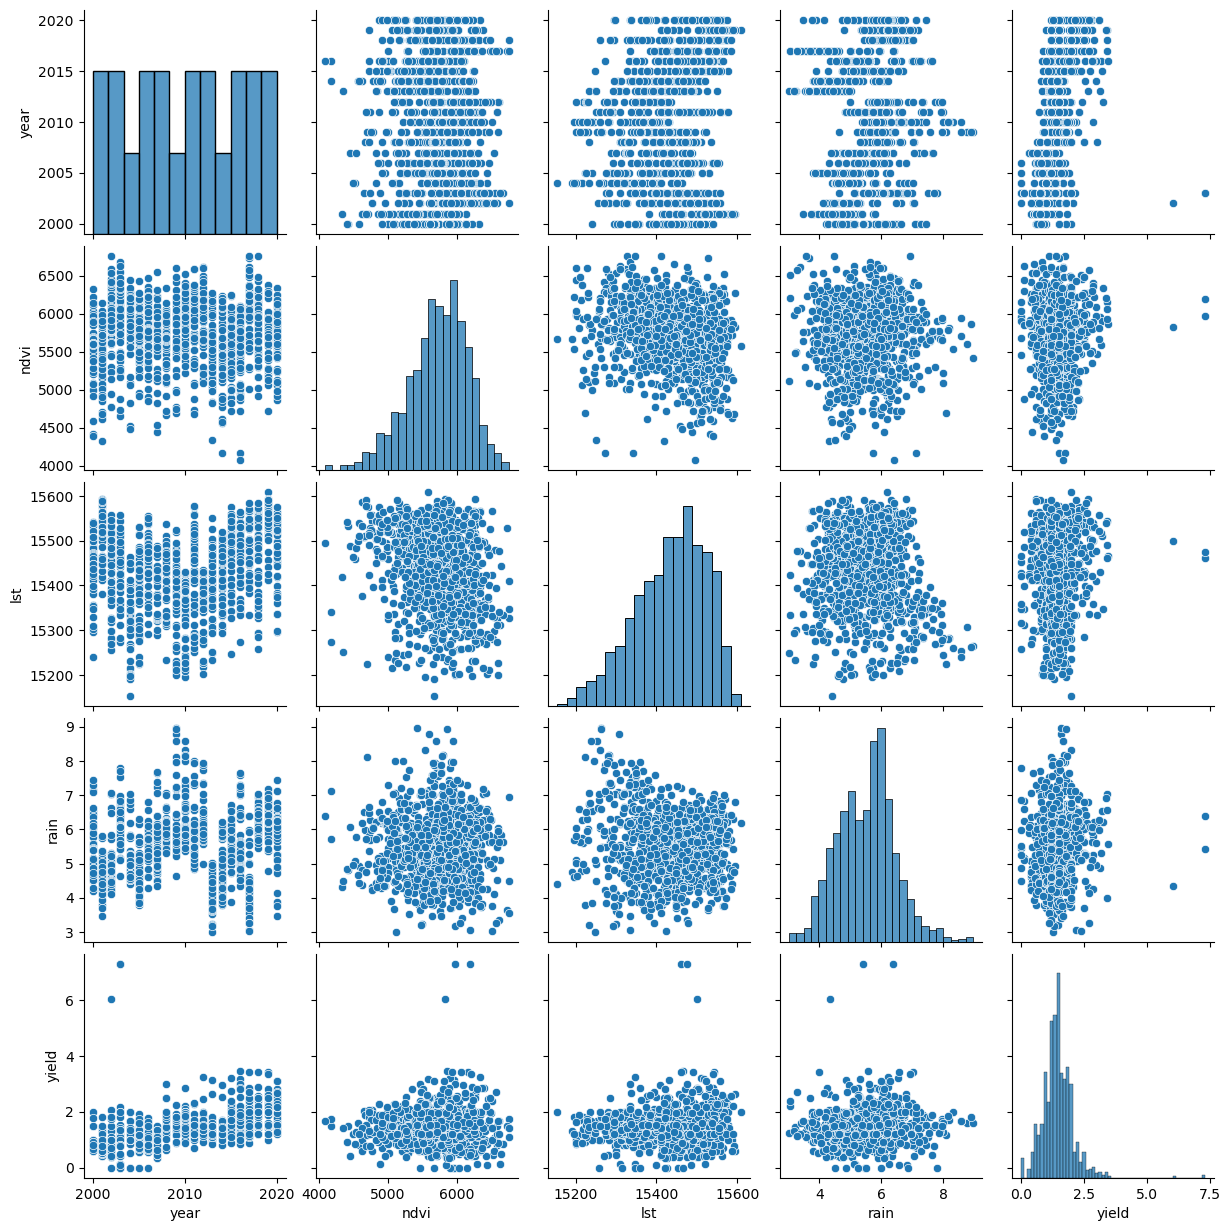

In [57]:
sns.pairplot(model_df)

In [58]:
# cannot have NAs in ML model, for now just going to drop it but can come up with better solution
model_df.isna().sum()

district_name      0
year               0
ndvi               0
lst                0
rain               0
yield            153
dtype: int64

In [59]:
model_df.dropna(axis=0, how='any', inplace=True)
model_df.isna().sum()
model_df.shape

(960, 6)

In [60]:
X = model_df[['year', 'ndvi', 'lst', 'rain']]
Y = model_df['yield']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

In [61]:
model = LinearRegression()
model.fit(X_train, Y_train)
Y_hat = model.predict(X_test)

In [62]:
MSE = mean_squared_error(Y_test, Y_hat)
RMSE = np.sqrt(MSE)
RMSE

0.7582221414630285

In [63]:
# pretty bad
RMSE/Y_test.std()

0.9358497179467555

In [64]:
RMSE/Y_test.mean()

0.5007358061360561

In [65]:
model_sm = sm.OLS(endog=Y, exog=sm.add_constant(X)).fit()

In [66]:
table = Stargazer([model_sm])
table

In [67]:
Y_hat

array([1.14376518, 1.60326829, 0.88634856, 0.86065112, 1.11393599,
       1.40624493, 1.41504871, 1.69890974, 1.52712896, 1.28043881,
       1.92136599, 1.91920494, 1.31580532, 1.84324995, 1.32006773,
       1.57260371, 1.08258156, 1.65100463, 1.67445944, 0.9080261 ,
       1.99463559, 1.22853848, 1.87440813, 1.21232152, 1.89431981,
       1.08424977, 1.02497736, 1.89120864, 1.53295515, 1.90135364,
       1.1242534 , 1.12195735, 1.71370466, 1.87577839, 1.31011631,
       1.50328705, 1.11712709, 1.72126173, 1.57424762, 1.92851154,
       1.16024861, 1.70071289, 1.23716868, 1.90186293, 1.36705719,
       1.72025308, 1.21398046, 1.14911537, 1.39999409, 1.84172401,
       1.54536265, 1.70639562, 1.52063841, 1.40734736, 0.89101346,
       1.47887937, 1.90777514, 1.91788604, 1.7008019 , 1.16262496,
       1.60655032, 1.65821877, 1.30732238, 1.66902737, 1.93036975,
       0.87150837, 1.93221909, 1.22464385, 1.29622509, 1.62091457,
       1.44721917, 0.84150207, 1.52897585, 1.07166264, 1.56672

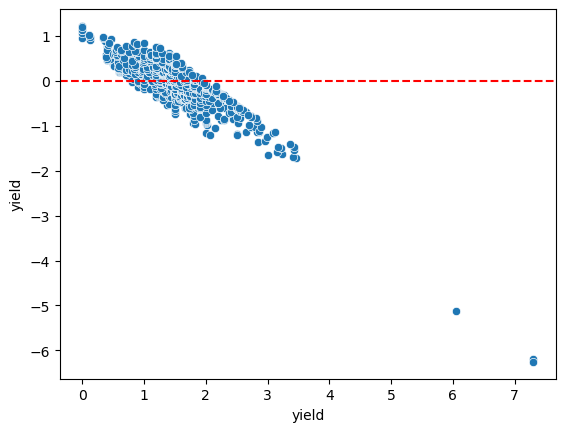

In [68]:
Y_hat_resid = model.predict(X)
residuals = Y_hat_resid-Y
sns.scatterplot(x=Y, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')

In [69]:
poly_df = model_df
poly_df['ndvi2'] = poly_df['ndvi'] ** 2
poly_df['lst2'] = poly_df['lst'] ** 2
poly_df['rain2'] = poly_df['rain'] ** 2
poly_df.head()

,district_name,year,ndvi,lst,rain,yield,ndvi2,lst2,rain2
0,Bawku,2000,4414.133649,15533.286044,4.807214,1.5,1.948458e+07,2.412830e+08,23.109302
1,BawkuWest,2000,5627.316414,15478.890897,4.839396,2.0,3.166669e+07,2.395961e+08,23.419755
3,Bole,2000,5094.237214,15295.688814,4.204937,1.0,2.595125e+07,2.339581e+08,17.681495
4,Bolgatanga,2000,6031.486869,15436.132054,4.479659,0.6,3.637883e+07,2.382742e+08,20.067348
5,Bongo,2000,5204.888441,15489.788024,4.285092,0.6,2.709086e+07,2.399335e+08,18.362016


In [70]:
X = poly_df.drop(['yield', 'year', 'district_name'], axis=1)
Y = poly_df['yield']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=103)
poly_model = LinearRegression()
poly_model.fit(X_train, Y_train)
Y_hat = poly_model.predict(X_test)

In [71]:
MSE = mean_squared_error(Y_test, Y_hat)
RMSE = np.sqrt(MSE)
RMSE

0.5848943000290466

In [72]:
RMSE/Y_test.std()

0.9790252955628752

In [73]:
X = model_df[['year', 'ndvi', 'lst', 'rain']]
Y = model_df['yield']

In [74]:
test_rmse = {}

for i in range(1, 6): 
    poly_convert = PolynomialFeatures(degree=i, include_bias=False)
    poly_vars = poly_convert.fit_transform(X)

    X_train, X_test, Y_train, Y_test = train_test_split(poly_vars, Y, test_size=0.3, random_state=1)

    model = LinearRegression()
    model.fit(X_train, Y_train) 

    Yhat_test = model.predict(X_test)

    testRMSE = np.sqrt(mean_squared_error(Y_test, Yhat_test))

    test_rmse[i] = testRMSE

# model evaluation
print("Lowest test RMSE Complexity Level: ", min(test_rmse, key=test_rmse.get))
print("Corresponding lowest test RMSE: ", min(test_rmse.values()))

Lowest test RMSE Complexity Level:  1
Corresponding lowest test RMSE:  0.5994480223881022


In [75]:
test_rmse

{1: 0.5994480223881022,
 2: 0.6002575154576387,
 3: 0.6072321845016321,
 4: 0.6561826224600882,
 5: 0.6868112663160152}

In [76]:
test_rmse[1]/Y_test.std()

0.8563964156923952